# 信息增益与上下文相关性

## 查看golden-irrelevant的entropy/acc分布

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

# 数据
`qwen-triviaqa.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "triviaqa"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

In [2]:
# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

data = load_pickle_file("output/data/qwen-triviaqa.pkl")
diff_entropy = []
diff_acc = []
for item in data["data"]:
    if check_item(item):
        diff_entropy.append(item["golden"]["entropy"] - item["irrelevant"]["entropy"])
        diff_acc.append(item["golden"]["accuracy_qwen"] - item["irrelevant"]["accuracy_qwen"])
print(f"valid data: {len(diff_entropy)}")

valid data: 1997


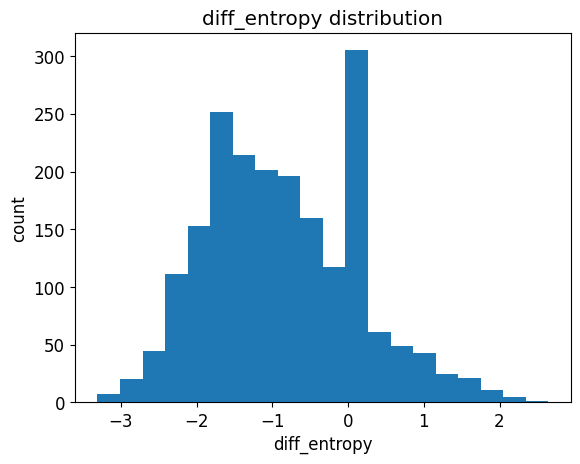

In [3]:
# 查看diff_entropy分布
plt.hist(diff_entropy, bins=20)
plt.xlabel("diff_entropy")
plt.ylabel("count")
plt.title("diff_entropy distribution")
plt.show()

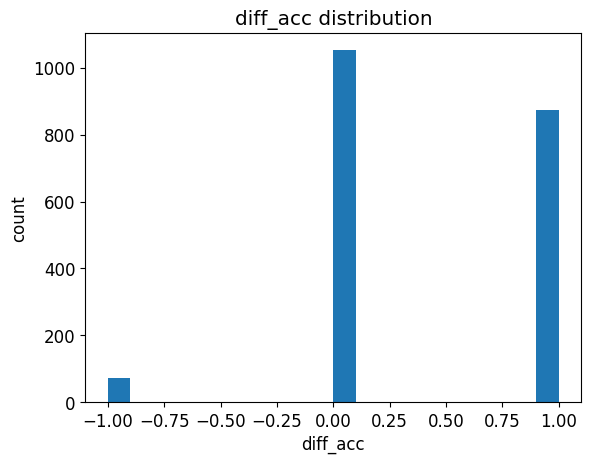

In [4]:
# 查看diff_acc分布
plt.hist(diff_acc, bins=20)
plt.xlabel("diff_acc")
plt.ylabel("count")
plt.title("diff_acc distribution")
plt.show()

In [5]:
# 计算相关性
print(f"correlation between diff_entropy and diff_acc: {scipy.stats.pearsonr(diff_entropy, diff_acc)}")


correlation between diff_entropy and diff_acc: PearsonRResult(statistic=-0.36001652599642786, pvalue=3.6124865771890188e-62)


In [6]:
# 将diff_entropy归一化到[-1, 1]
normal_diff_entropy = np.array(diff_entropy)
normal_diff_entropy = (normal_diff_entropy - np.min(normal_diff_entropy)) / (np.max(normal_diff_entropy) - np.min(normal_diff_entropy))
normal_diff_entropy = 1 - 2 * normal_diff_entropy

# 计算相关性
print(f"correlation between normal_diff_entropy and diff_acc: {scipy.stats.pearsonr(normal_diff_entropy, diff_acc)}")


correlation between normal_diff_entropy and diff_acc: PearsonRResult(statistic=0.36001652599642786, pvalue=3.6124865771890188e-62)


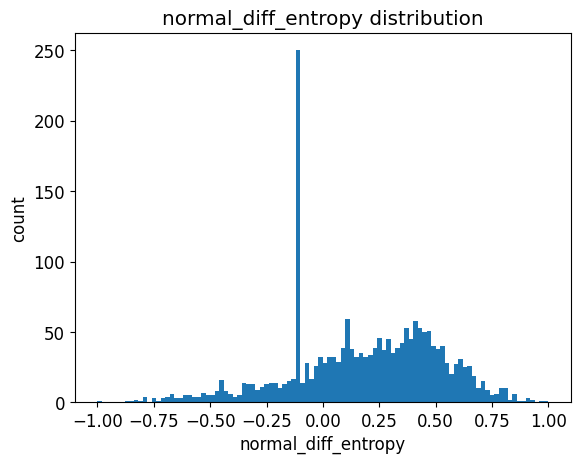

In [7]:
# 查看normal_diff_entropy分布
plt.hist(normal_diff_entropy, bins=100)
plt.xlabel("normal_diff_entropy")
plt.ylabel("count")
plt.title("normal_diff_entropy distribution")
plt.show()

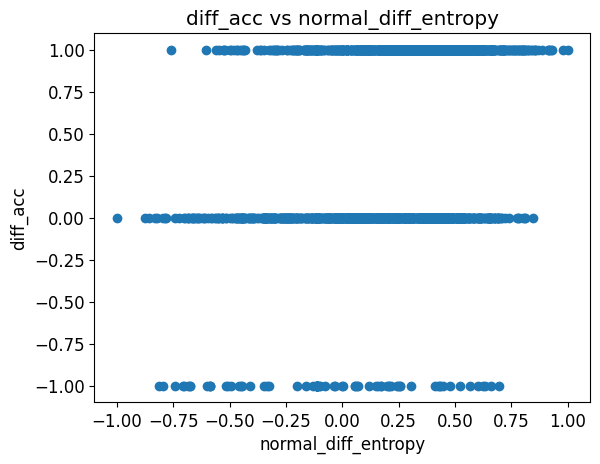

In [8]:
# 查看diff_acc和normal_diff_entropy的相关性
plt.scatter(normal_diff_entropy, diff_acc)
plt.xlabel("normal_diff_entropy")
plt.ylabel("diff_acc")
plt.title("diff_acc vs normal_diff_entropy")
plt.show()

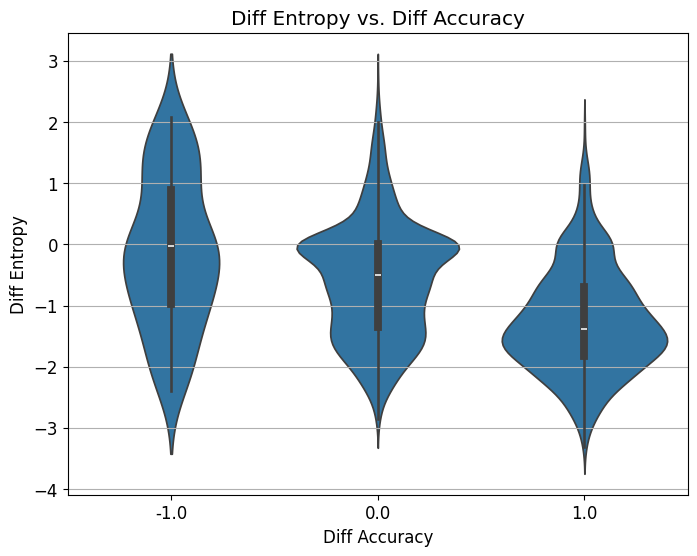

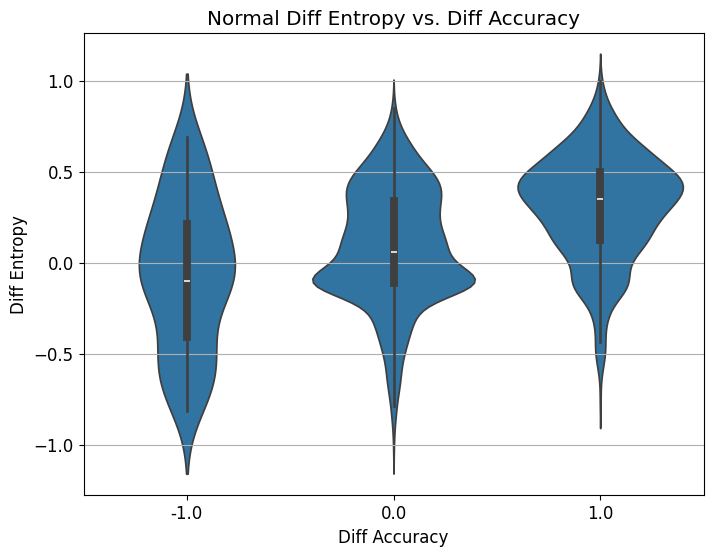

In [9]:
'''
提琴图
- entropy是连续值(-inf，+inf)，accuracy是离散值{-1, 0, 1}
- inner="box" 会在提琴图内嵌入箱型图，展示数据的基本统计特征。
- 如果希望仅展示密度信息，可以将 inner="box" 替换为 inner=None。
'''
def plot_violinplot(entropy, accuracy, title=''):
    import torch
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # 转换为 Pandas DataFrame
    data = pd.DataFrame({'entropy': entropy.numpy(), 'accuracy': accuracy.numpy()})

    # 绘制提琴图
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='accuracy', y='entropy', data=data, inner="box")  # inner="box" 显示箱线信息
    # sns.violinplot(x='accuracy', y='entropy', data=data, inner=None)
    plt.title(title)
    plt.xlabel("Diff Accuracy")
    plt.ylabel("Diff Entropy")
    plt.grid(axis='y')
    plt.show()

plot_violinplot(torch.tensor(diff_entropy), torch.tensor(diff_acc), title='Diff Entropy vs. Diff Accuracy')
plot_violinplot(torch.tensor(normal_diff_entropy), torch.tensor(diff_acc), title='Normal Diff Entropy vs. Diff Accuracy')

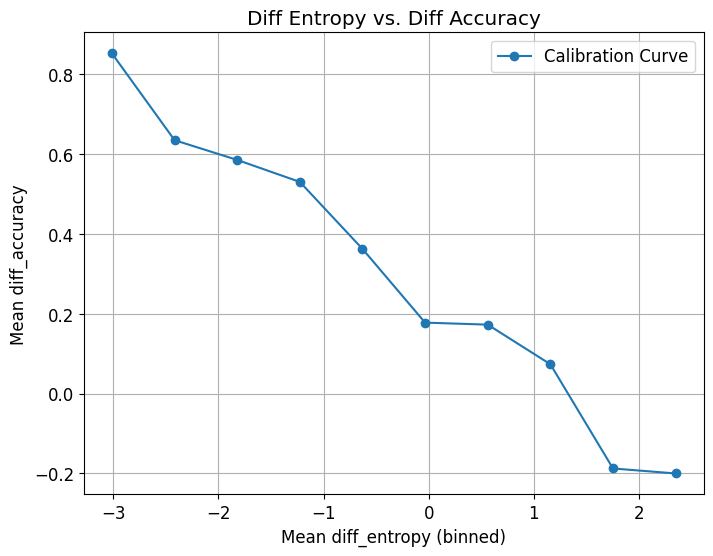

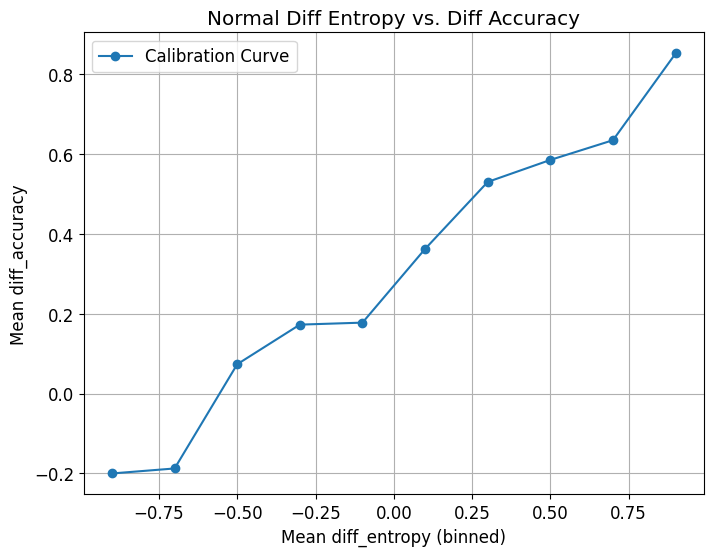

In [10]:
def plot_calibration_curve(diff_entropy, diff_accuracy, title='', num_bins=10):
    """
    绘制校准曲线，观测 diff_entropy 和 diff_accuracy 的关系

    参数:
    - diff_entropy (torch.Tensor): 表示熵差异的张量，形状为 [N]
    - diff_accuracy (torch.Tensor): 表示准确率差异的张量，形状为 [N]
    - num_bins (int): 分桶的数量，默认值为 10

    返回:
    - None
    """
    import torch
    import matplotlib.pyplot as plt

    # 分桶
    bin_edges = torch.linspace(diff_entropy.min(), diff_entropy.max(), num_bins + 1)
    bin_indices = torch.bucketize(diff_entropy, bin_edges)

    # 计算每个桶中 diff_entropy 和 diff_accuracy 的平均值
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean_diff_accuracy = [
        diff_accuracy[bin_indices == i].mean().item() if (bin_indices == i).sum() > 0 else None
        for i in range(1, num_bins + 1)
    ]

    # 绘制校准曲线
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, mean_diff_accuracy, marker='o', label="Calibration Curve")
    plt.title(title)
    plt.xlabel("Mean diff_entropy (binned)")
    plt.ylabel("Mean diff_accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

# todo: ???????
plot_calibration_curve(torch.tensor(diff_entropy), torch.tensor(diff_acc), title='Diff Entropy vs. Diff Accuracy', num_bins=10)
plot_calibration_curve(torch.tensor(normal_diff_entropy), torch.tensor(diff_acc), title='Normal Diff Entropy vs. Diff Accuracy', num_bins=10)

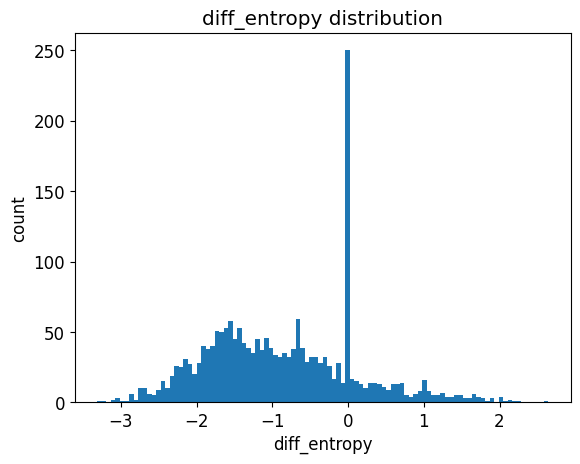

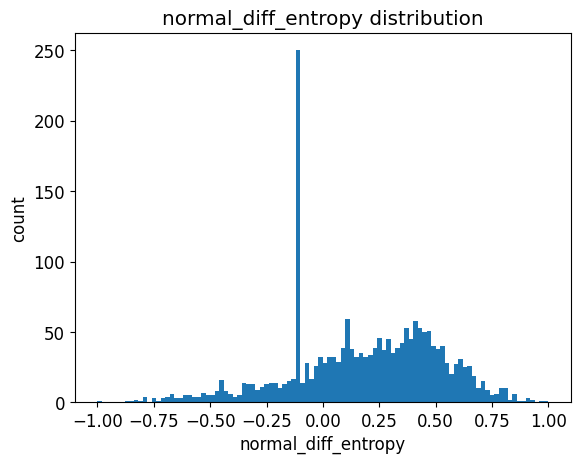

In [11]:
# 查看diff_entropy分布
plt.hist(diff_entropy, bins=100)
plt.xlabel("diff_entropy")
plt.ylabel("count")
plt.title("diff_entropy distribution")
plt.show()

# 查看normal_diff_entropy分布
plt.hist(normal_diff_entropy, bins=100)
plt.xlabel("normal_diff_entropy")
plt.ylabel("count")
plt.title("normal_diff_entropy distribution")
plt.show()